Load corpus

In [2]:
import pandas as pd
import numpy as np
import json
import csv

seasons = pd.read_csv("./data/bangumi.csv", delimiter=",", encoding="utf-8")
episodes = pd.read_csv("./data/episode.csv", delimiter=",", encoding="utf-8")
danmaku_complete = pd.read_csv("./data/danmaku_complete.csv", delimiter="\t", encoding="utf-8", quoting=csv.QUOTE_NONE, low_memory=False)
danmaku_complete = danmaku_complete.fillna(-1)
danmaku_complete.shape

(21573874, 8)

word segment

In [3]:
import jieba.posseg as segtool
import re

ACCEPTABLE_TYPE = {'n', 't', 's', 'f', 'v', 'a', 'b', 'z', 'e', 'y', 'o'}
REPLACE_DICT = {
    "233+": "233",
    "666+": "666"
}

def check_type(word_type):
    if word_type[0] in ACCEPTABLE_TYPE:
        return True
    else:
        return False

def check_replace(word):
    for item in REPLACE_DICT.keys():
        pattern = re.compile(item)
        if re.match(pattern, word) is not None:
            new_word = REPLACE_DICT[item]
            return new_word
    return word

def word_segment(content):
    words = []
    results = segtool.cut(content)
    for result in results:
        result.word = check_replace(result.word)
        if check_type(result.flag):
            words.append(result.word)
    return words

dataset definition

In [4]:
import torch
import torch.utils.data as data
import math
import numpy as np
import pandas as pd
import random
import collections

class DmDataset(data.Dataset):
    def __init__(self, dm_samples, context_size, min_count, neg_sampling_num):
        self.neg_sampling_num = neg_sampling_num
        print('building vocabulary...')
        aggregate_sample = []
        for sample in dm_samples:
            aggregate_sample.extend(sample)
        counter = {'UNK': 0}
        counter.update(collections.Counter(aggregate_sample).most_common())
        rare_words = set()
        for word in counter:
            if word != 'UNK' and counter[word] <= min_count:
                rare_words.add(word)
        for word in rare_words:
            counter['UNK'] += counter[word]
            counter.pop(word)
        print('%d words founded in vocabulary' % len(counter))
        
        self.vocab_counter = counter
        self.word_to_ix = dict()
        for word in counter:
            self.word_to_ix[word] = len(self.word_to_ix)
            
        counts = [self.vocab_counter[key] for key in self.vocab_counter]
        frequency = np.array(counts)/sum(counts)
        self.subsampling_P = dict()
        for idx, x in enumerate(frequency):
            y = (math.sqrt(x/0.001)+1)*0.001/x
            self.subsampling_P[idx] = y
            
        pow_frequency = np.array(counts)**0.75
        power = sum(pow_frequency)
        self.neg_sampling_ratio = pow_frequency/ power
        
        print('building samples...')
        self.samples = []
        span = context_size*2+1
        for sample in dm_samples:
            # skip heading and tailing words
            # subsampling
            sample_ = []
            for word in sample:
                word_ix = self.word2ix(word)
                if random.random() < self.subsampling_P[word_ix]:
                    sample_.append(word_ix)
            # generate word pair
            start_index = 0
            done = False
            while start_index + span <= len(sample_):
                buffer = sample_[start_index: start_index + span]
                done = True
                target_word = buffer[context_size]
                for index in range(0, len(buffer)):
                    if index != context_size:
                        self.samples.append((target_word, buffer[index]))
            if not done:
                buffer = sample_[:]
                if len(buffer)>1:
                    target_word = buffer[len(buffer)//2]
                    for index in range(0, len(buffer)):
                        if index != len(buffer)//2:
                            self.samples.append((target_word, buffer[index]))
    
        print('%d samples constructed.' % len(self.samples))
        return
    
    
    def word2ix(self, word):
        if word in self.word_to_ix:
            return self.word_to_ix[word]
        else:
            return self.word_to_ix['UNK']
 

    def __getitem__(self, index):
        sample = self.samples[index]
        target = sample[0]
        context = sample[1]
        neg_samples = np.random.choice(len(self.vocab_counter), self.neg_sampling_num, self.neg_sampling_ratio)
        return target, context, np.array(neg_samples)

    
    def __len__(self):
        return len(self.samples)
    
    
    def save_vocab(self, path):
        vocab = []
        for word in self.vocab_counter:
            vocab.append({'idx': self.word_to_ix[word],
                          'word': word,
                          'count': self.vocab_counter[word]})
        df = pd.DataFrame(vocab)
        df.to_csv(path, index=False)
        return


data preprocess

In [ ]:
danmaku_selected = danmaku_complete[danmaku_complete['episode_id']==173248]

context_size = 3
min_count = 5
neg_sampling_num = 10
samples = []

for index, row in danmaku_selected.iterrows():
    content = row['content']
    words = word_segment(content)
    samples.append(words)

dm_set = DmDataset(samples, context_size, min_count, neg_sampling_num)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/w9/1mf4l9j16f1_8x6smdnknjm00000gn/T/jieba.cache
Loading model cost 1.233 seconds.
Prefix dict has been built succesfully.


building vocabulary...
2877 words founded in vocabulary
building samples...


Network definition

In [6]:
import torch as t
from torch import nn
from torch.autograd import Variable as V
import torch.nn.functional as F

class SkipGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramLanguageModeler, self).__init__()
        self.u_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)   
        self.v_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True) 
        self.embedding_dim = embedding_dim
        self.init_emb()
        
    def init_emb():
        initrange = 0.5 / self.embedding_dim
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)

    def forward(self, u_pos, v_pos, v_neg, batch_size):
        embed_u = self.u_embeddings(u_pos)
        embed_v = self.v_embeddings(v_pos)

        score  = torch.mul(embed_u, embed_v)
        score = torch.sum(score, dim=1)
        log_target = F.logsigmoid(score).squeeze()
    
        neg_embed_v = self.v_embeddings(v_neg)
    
        neg_score = torch.bmm(neg_embed_v, embed_u.unsqueeze(2)).squeeze()
        neg_score = torch.sum(neg_score, dim=1)
        sum_log_sampled = F.logsigmoid(-1*neg_score).squeeze()

        loss = log_target + sum_log_sampled

        return -1*loss.sum()/batch_size

training phase

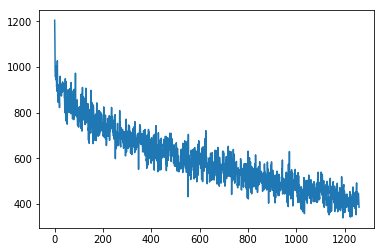

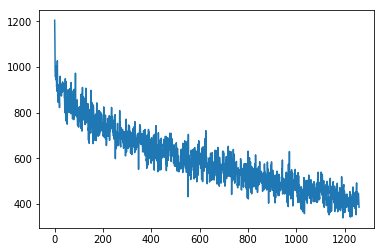

In [14]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
def plot_durations(y):
    plt.figure(1)
    plt.clf()
    plt.plot(y)

#     plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

torch.manual_seed(1) 

EMBEDDING_DIM = 200
batch_size=128

dm_dataloader = Data.DataLoader(
    dataset=dm_set,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=8
)
